<h1><center>GALACTIC DYNAMO</center></h1>

This project is a part of the term project given in course P464 Plamsa Physics and Magnetohydrodynamics taught in Spring 2024 at NISER Bhubaneswar.

Submitted by: Chandan Kumar Sahu, Integrated MSc. SPS batch 19

Supervised by: Dr. Luke R. Chamandy, SPS, NISER



# Contents
1. Introduction
2. Theory
    1. Derivation of necessary equations
3. Numerical solution to Galactic Magnetic Fields
    1. Problem Statement
    2. Numerical solution
    3. Magnetic field evolution with free boundary conditions
    4. Isolated boundary conditions

# 1 - Introduction

Write something here

# 2 - Theory

Write something here

### 2.1 - Derivation of the necessary equations

We have the mean-field induction equation as 
$$ \dfrac{\partial \bar{\mathbf{B}}}{\partial t} = \nabla \times \left[ \bar{\mathbf{V}} \times \bar{\mathbf{B}} + \mathcal{E} - \eta \left( \nabla \times \bar{\mathbf{B}} \right) \right] $$
where $\mathcal{E} = \left( \alpha \bar{\mathbf{B}} \right) - \eta_t \left( \nabla \times \bar{\mathbf{B}} \right)$

We will solve the equations in the cylindrical coordinates (r, $\phi$, z) with the origin at the galactic centre and the z-axis parallel to the galactic angular velocity. However, to simplify things, lets make some approximations.

1. Omit the terms involving $\bar{\mathbf{V}} \times \bar{\mathbf{B}}$ and $\alpha$. We will land up on just the diffusion equation.
$$ \dfrac{\partial \bar{\mathbf{B}}}{\partial t} = - \nabla \times \left[ \eta_T \left( \nabla \times \bar{\mathbf{B}} \right) \right] $$
where $\eta_T = \eta + \eta_t$

2. Take $\eta_T$ independent of $\bar{\mathbf{B}}$. Our equation becomes
$$ \dfrac{\partial \bar{\mathbf{B}}}{\partial t} = - \eta_T \left[ \nabla \times \left( \nabla \times \bar{\mathbf{B}} \right) \right] $$
But $\nabla \times \left( \nabla \times \bar{\mathbf{B}} \right) = \nabla \left( \nabla \cdot \bar{\mathbf{B}} \right) - \nabla^2 \bar{\mathbf{B}} $ and $\nabla \cdot \bar{\mathbf{B}} = 0$ (Gauss's Law), so we finally have
$$ \boxed{ \dfrac{\partial \bar{\mathbf{B}}}{\partial t} = \eta_T \nabla^2 \bar{\mathbf{B}} }$$

This is the Fickian diffusion equation. We will solve this equation numerically.


In cylindrical coordinates, the $\nabla^2B$ becomes

$$ \begin{aligned}
\nabla^2 \mathbf{B} = & \left[ \frac{\partial}{\partial r} \left( \frac{1}{r} \frac{\partial}{\partial r} \left( r B_r \right) \right) + \frac{1}{r^2} \frac{\partial^2 B_r}{\partial \phi^2} + \frac{\partial^2 B_r}{\partial z^2} - \frac{2}{r^2} \frac{\partial B_\phi}{\partial \phi} \right] \mathbf{\hat{r}} \\
& + \left[ \frac{\partial}{\partial r} \left( \frac{1}{r} \frac{\partial}{\partial r} \left( r B_\phi \right) \right) + \frac{1}{r^2} \frac{\partial^2 B_\phi}{\partial \phi^2} + \frac{\partial^2 B_\phi}{\partial z^2}+\frac{2}{r^2} \frac{\partial B_r}{\partial \phi} \right] \mathbf{\hat{\phi}} \\
& + \left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \frac{\partial B_z}{\partial r}\right)+\frac{1}{r^2} \frac{\partial^2 B_z}{\partial \phi^2}+\frac{\partial^2 B_z}{\partial z^2}\right] \mathbf{\hat{z}} 
\end{aligned} $$

So we get the final component-wise equations as
$$ \begin{aligned}
    \frac{\partial \bar{B}_r}{\partial t} &= \eta_T \left[ \frac{\partial}{\partial r} \left( \frac{1}{r} \frac{\partial}{\partial r} \left( r B_r \right) \right) + \frac{1}{r^2} \frac{\partial^2 B_r}{\partial \phi^2} + \frac{\partial^2 B_r}{\partial z^2} - \frac{2}{r^2} \frac{\partial B_\phi}{\partial \phi} \right] \\
    \frac{\partial \bar{B}_\phi}{\partial t} &= \eta_T \left[ \frac{\partial}{\partial r} \left( \frac{1}{r} \frac{\partial}{\partial r} \left( r B_\phi \right) \right) + \frac{1}{r^2} \frac{\partial^2 B_\phi}{\partial \phi^2} + \frac{\partial^2 B_\phi}{\partial z^2}+\frac{2}{r^2} \frac{\partial B_r}{\partial \phi} \right] \\
    \frac{\partial \bar{B}_z}{\partial t} &= \eta_T \left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \frac{\partial B_z}{\partial r}\right)+\frac{1}{r^2} \frac{\partial^2 B_z}{\partial \phi^2}+\frac{\partial^2 B_z}{\partial z^2}\right] 
\end{aligned} $$

Since the problem statement in the project aims to solve only in the z-direction, we remove all radial or azimuthal variations of the magnetic field $\left(\dfrac{\partial }{\partial r} = \dfrac{\partial }{\partial \phi} = 0 \right)$. 

We are now left with these simple equations to solve, i.e., the Fickian diffusion equations.
$$ \boxed{ \frac{\partial \bar{B}_r}{\partial t} = \eta_T \frac{\partial^2 \bar{B}_r}{\partial z^2} } \qquad \qquad \qquad \boxed{ \frac{\partial \bar{B}_\phi}{\partial t} = \eta_T \frac{\partial^2 \bar{B}_\phi}{\partial z^2} } \qquad \qquad \qquad \boxed{ \frac{\partial \bar{B}_z}{\partial t} = \eta_T \frac{\partial^2 \bar{B}_z}{\partial z^2} } $$



# 3 - Numerical Solution to Galactic magnetic Fields

Write something here


### 3.1 - Problem Statement

Solve the diffusion equation in the z-direction.
* Explore the evolution of the magnetic field magnitude and of the exponential decay rate.
* Explore the evolution of the spatial solution for $B_r$ and $B_\phi$, and of the pitch angle of the mean magnetic field p.
* Explore how different boundary conditions affect the results.
* Explore how different seed fields affect the results.

### 3.2 - Numerical solution

Write something here


In [1]:
# Importing required libraries
import matplotlib.pyplot as plt
import numpy as np


Let's first define the function to solve the heat diffusion equation using Crank-Nicolson method. 

We need to specify the boundary conditions first. The guiding matrices need to be defined for solving the system.
Here we have written two different boundary conditions, one for free boundaries and another for isolated boundaries. 


In [2]:
"""
Get the matrices A and B for solving the diffusion equation using Crank-Nicolson method.
This function is used for free boundary conditions.

Parameters:
- N: Number of spatial grid points
- sigma: alpha*dt/dx^2

Returns:
- A: Matrix A
- B: Matrix B
"""

def diff_matrix_free_boundary(N, sigma):
    # Initialize matrices A and B with zeros
    A = [[0] * N for _ in range(N)]
    B = [[0] * N for _ in range(N)]

    # Interior points
    for i in range(0, N):
        A[i][i] = 2 + 2 * sigma  # Diagonal element of A
        B[i][i] = 2 - 2 * sigma  # Diagonal element of B

        # Connect to the left neighbor (if not on the left edge)
        if i > 0:
            A[i][i - 1] = -sigma
            B[i][i - 1] = sigma

        # Connect to the right neighbor (if not on the right edge)
        if i < N - 1:
            A[i][i + 1] = -sigma
            B[i][i + 1] = sigma

    return A, B


"""
Get the matrices A and B for solving the diffusion equation using Crank-Nicolson method.
This function is used for isolated boundary conditions.

Parameters:
- N: Number of spatial grid points
- sigma: alpha*dt/dx^2

Returns:
- A: Matrix A
- B: Matrix B
"""

def diff_matrix_isolated_boundary(N, sigma):
    # Initialize matrices A and B with zeros
    A = [[0] * N for _ in range(N)]
    B = [[0] * N for _ in range(N)]

    # Fill diagonal and off-diagonal values for matrices A and B
    for i in range(N):
        A[i][i] = 2 + 2 * sigma  # Diagonal element of A
        B[i][i] = 2 - 2 * sigma  # Diagonal element of B

        # Connect to the left neighbor (if not on the left edge)
        if i > 0:
            A[i][i - 1] = -sigma
            B[i][i - 1] = sigma

        # Connect to the right neighbor (if not on the right edge)
        if i < N - 1:
            A[i][i + 1] = -sigma
            B[i][i + 1] = sigma

    # Boundary conditions
    A[0][0] = 2 + sigma
    B[0][0] = 2 - sigma
    A[-1][-1] = 2 + sigma
    B[-1][-1] = 2 - sigma

    return A, B


Now we define the Crank-Nicholson semi-implicit algorithm to find the solution.
This algorithm is very stable compared to other explicit methods such as Runge-Kutta or Euler methods.
Here we take the normalized boundaries, i.e., the values have been normalized to $-1<z<1$

In [3]:


"""
Solve 1D diffusion equation using Crank-Nicolson method.

Parameters:
- x_max: Extent of the spatial domain
- t_max: Total simulation time
- dx: Spatial step size
- dt: Time step size
- Diff: Thermal diffusivity
- init_cond: Initial condition function
- source_term: Source term function
- boundary: Boundary condition function

Returns:
- u: Temperature distribution over space and time
- x: Spatial grid
- t: Time grid
"""

def crank_nicolson_diffusion(x_min, x_max, t_max, dx, dt, Diff, init_cond, source_term, boundary):

    alpha = Diff * dt / (dx**2)

    # Spatial grid
    x = [x_min+i*dx for i in range(int((x_max-x_min)/dx)+1)]
    t = [j*dt for j in range(int(t_max/dt)+1)]

    # Initialize temperature array
    Temp = np.zeros((len(x), len(t)))

    # Initial condition
    for i in range(len(x)):
        Temp[i][0] = init_cond(x[i])

    # Get the matrices for solving the matrix using crank-nicolson method
    A, B = boundary(len(x), alpha)

    A = np.array(A)
    B = np.array(B)

    for j in range(1, len(t)):
        source_vector = np.array([source_term(xi, t[j]) for xi in x])
        Temp[:, j] = np.linalg.solve(A, np.dot(B, Temp[:, j - 1]) + dt * source_vector)

    return Temp, np.array(x), np.array(t)


We now define the plotting function

In [4]:

"""
Plot the solution in both 1D and Heatmap format.

Parameters:
- time_grid: Time grid
- spatial_grid: Spatial grid
- solution: Solution of the diffusion equation

Returns:
- Makes the plots
"""

def plot_diff(time_grid, spatial_grid, solution_r, solution_phi):

    # Create 2D plots
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    for i in (range(0, len(time_grid), int(len(time_grid)/5))):
        plt.plot(spatial_grid, solution_r[:, i], label=f'time = {time_grid[i]:.1f}')
    plt.xlabel(r'$z$ (normalized to 100 pc)')
    plt.ylabel(r'Magnetic Field Strength ($B_r$)')
    plt.title('Diffusion of Magnetic field in radial direction')
    # plt.ylim(np.min(solution_r), np.max(solution_r))
    plt.grid()
    plt.legend()

    # Create imshow plot
    plt.subplot(2, 2, 2)
    plt.contourf(*np.meshgrid(spatial_grid, time_grid), solution_r.T, 40, cmap='Spectral_r')
    plt.colorbar(label=r'Magnetic Field Strength ($B_r$)')
    plt.title(r'Diffusion of Magnetic field in radial direction')
    plt.xlabel(r'$z$ (normalized to 100 pc)')
    plt.ylabel(r'Time (Myr)')
    plt.grid()


    # Create 2D plots
    plt.subplot(2, 2, 3)
    for i in (range(0, len(time_grid), int(len(time_grid)/5))):
        plt.plot(spatial_grid, solution_phi[:, i], label=f'time = {time_grid[i]:.1f}')
    plt.xlabel(r'$z$ (normalized to 100 pc)')
    plt.ylabel(r'Magnetic Field Strength ($B_\phi$)')
    plt.title(r'Diffusion of Magnetic field in azimuthal direction')
    # plt.ylim(np.min(solution_phi), np.max(solution_phi))
    plt.grid()
    plt.legend()

    # Create imshow plot
    plt.subplot(2, 2, 4)
    plt.contourf(*np.meshgrid(spatial_grid, time_grid), solution_phi.T, 40, cmap='Spectral_r')
    plt.colorbar(label=r'Magnetic Field Strength ($B_\phi$)')
    plt.title('Diffusion of Magnetic field in azimuthal direction')
    plt.xlabel(r'$z$ (normalized to 100 pc)')
    plt.ylabel('Time (Myr)')
    plt.grid()

    plt.tight_layout(pad=3)


We now move to the solution. 

### 3.3 - Magnetic field evolution with free boundary conditions

Write something here


### Values
$z$: The typical thickness of a thin disk is ~200 pc. For solving numerically, we normalize the solutions to -1 to 1, hence $-1<z<1$. 

For $\eta_T$, we need to calculate its value in he normlization units.
$$ \eta_T = \dfrac{1}{3} \tau v_{\text{rms}}^2 $$

We have, for a typical galaxy, $\tau \approx 1-10$ Myr and $v_{\text{rms}} \approx 10^4$ km/s
$$ \begin{aligned}
\eta_T &= \dfrac{1}{3} \times 10 \text{ Myrs} \times (10 \text{ km/s})^2 \\
&= \dfrac{100}{3} \times \text{ Myrs} \times  \dfrac{\text{ km}^2}{\text{s}^2} \\
&= \dfrac{100}{3} \times \text{ Myrs} \times  \left( \dfrac{\text{ km} \times 100 \text{ pc}}{3.086\times 10^{15}\text{ km}} \right)^2 \left(\dfrac{3.154\times 10^{13} \text{ s}}{\text{s} \times \text{Myr}} \right)^2 \\
&= \dfrac{100}{3} \times \left( \dfrac{3.154\times 10^{13}}{3.086\times 10^{15}} \right)^2 \times \text{ (100 pc)}^2/\text{ Myr} \\
&= 3.48 \times 10^{-3}\text{ (100 pc)}^2/\text{ Myr}
\end{aligned} $$

Hence, we use the following values
$$ -1<z<1 \qquad \qquad \text{ and } \qquad \qquad \eta_T = 3.48 \times 10^{-3}\text{ (100 pc)}^2/\text{ Myr} $$


In [5]:

def plot_pitch(time_grid, spatial_grid, B, pitch):

    # Create 2D plots
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    for i in (range(0, len(time_grid), int(len(time_grid)/5))):
        plt.plot(spatial_grid, B[:, i], label=f'time = {time_grid[i]:.1f}')
    plt.xlabel(r'$z$ (normalized to 100 pc)')
    plt.ylabel(r'Magnetic Field Strength ($B_r$)')
    plt.title('Diffusion of Magnetic field in radial direction')
    # plt.ylim(np.min(solution_r), np.max(solution_r))
    plt.grid()
    plt.legend()

    # Create imshow plot
    plt.subplot(2, 2, 2)
    plt.contourf(*np.meshgrid(spatial_grid, time_grid), B.T, 40, cmap='Spectral_r')
    plt.colorbar(label=r'Magnetic Field Strength ($B_r$)')
    plt.title(r'Diffusion of Magnetic field in radial direction')
    plt.xlabel(r'$z$ (normalized to 100 pc)')
    plt.ylabel(r'Time (Myr)')
    plt.grid()


    # Create 2D plots
    plt.subplot(2, 2, 3)
    for i in (range(0, len(time_grid), int(len(time_grid)/5))):
        plt.plot(spatial_grid, pitch[:, i], label=f'time = {time_grid[i]:.1f}')
    plt.xlabel(r'$z$ (normalized to 100 pc)')
    plt.ylabel(r'Magnetic Field Strength ($B_\phi$)')
    plt.title(r'Diffusion of Magnetic field in azimuthal direction')
    # plt.ylim(np.min(solution_phi), np.max(solution_phi))
    plt.grid()
    plt.legend()

    # Create imshow plot
    plt.subplot(2, 2, 4)
    plt.contourf(*np.meshgrid(spatial_grid, time_grid), pitch.T, 40, cmap='Spectral_r')
    plt.colorbar(label=r'Magnetic Field Strength ($B_\phi$)')
    plt.title('Diffusion of Magnetic field in azimuthal direction')
    plt.xlabel(r'$z$ (normalized to 100 pc)')
    plt.ylabel('Time (Myr)')
    plt.grid()

    plt.tight_layout(pad=3)

# Pitch angle
def get_B_and_pitch(Br, Bphi):
    B = np.sqrt(Br**2 + Bphi**2)
    p = np.where(Bphi!=0, 180/np.pi*np.arctan(Br/Bphi), np.where(Br==0, 0, 90))
    return B, p


#### 3.3.1 - Symmetric initial condition
Let us start with a symmetric initial condition, say a gaussian magnetic field which has a maxima at the midplane.


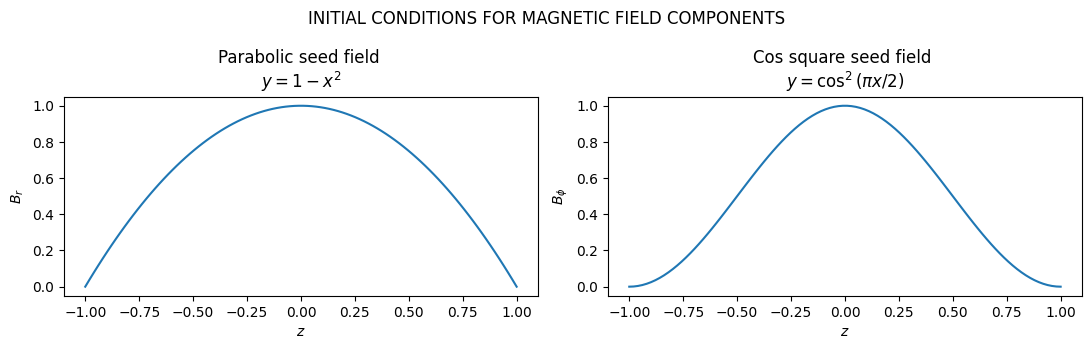

In [6]:
def init_cond_Br(x):
    return 1-x**2
def init_cond_Bphi(x):
    return np.cos(np.pi/2*x)**2

plt.figure(figsize=(11, 3.5))

z = np.linspace(-1, 1, 100)
plt.subplot(121)
plt.plot(z, init_cond_Br(z))
plt.xlabel(r'$z$')
plt.ylabel(r'$B_r$')
plt.title(r'Parabolic seed field '+'\n'+r'$ y = 1-x^2$')

plt.subplot(122)
plt.plot(z, init_cond_Bphi(z))
plt.xlabel(r'$z$')
plt.ylabel(r'$B_{\phi}$')
plt.title(r'Cos square seed field '+'\n'+r'$ y = \cos^2(\pi x/2)$')

plt.suptitle('INITIAL CONDITIONS FOR MAGNETIC FIELD COMPONENTS')
plt.tight_layout(pad=1)
plt.show()

The final solution is then calculated and plotted.

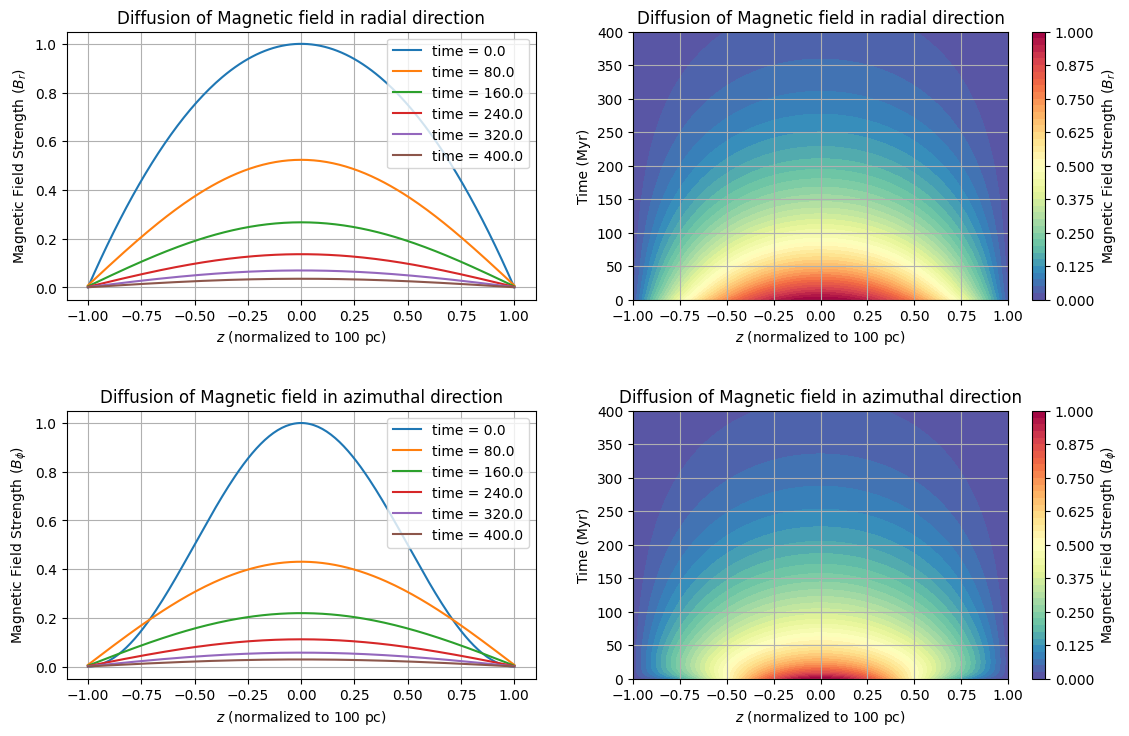

In [7]:
def init_cond_Br(x):
    return 1-x**2
def init_cond_Bphi(x):
    return np.cos(np.pi/2*x)**2

def source_term(x, t):
    return 0 # 10 * np.sin(np.pi * x) * np.exp(-0.1 * t)

# Constants and parameters
eta_T = 3.48e-3    # magnetic diffusivity
t_max = 400     # total simulation time
z_min = -1.0     # minimum thickness of the disc
z_max = 1.0     # thickness of the disc
dt = 1       # time step
dz = 0.01       # spatial step in z direction

# Solve the diffusion equation in radial direction
solution_r, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Br, source_term, diff_matrix_free_boundary)
# Solve the diffusion equation in azimuthal direction
solution_phi, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Bphi, source_term, diff_matrix_free_boundary)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_r, solution_phi)

plt.show()


/tmp/ipykernel_251065/4095974397.py:50: RuntimeWarning: divide by zero encountered in divide
  p = np.where(Bphi!=0, 180/np.pi*np.arctan(Br/Bphi), np.where(Br==0, 0, 90))


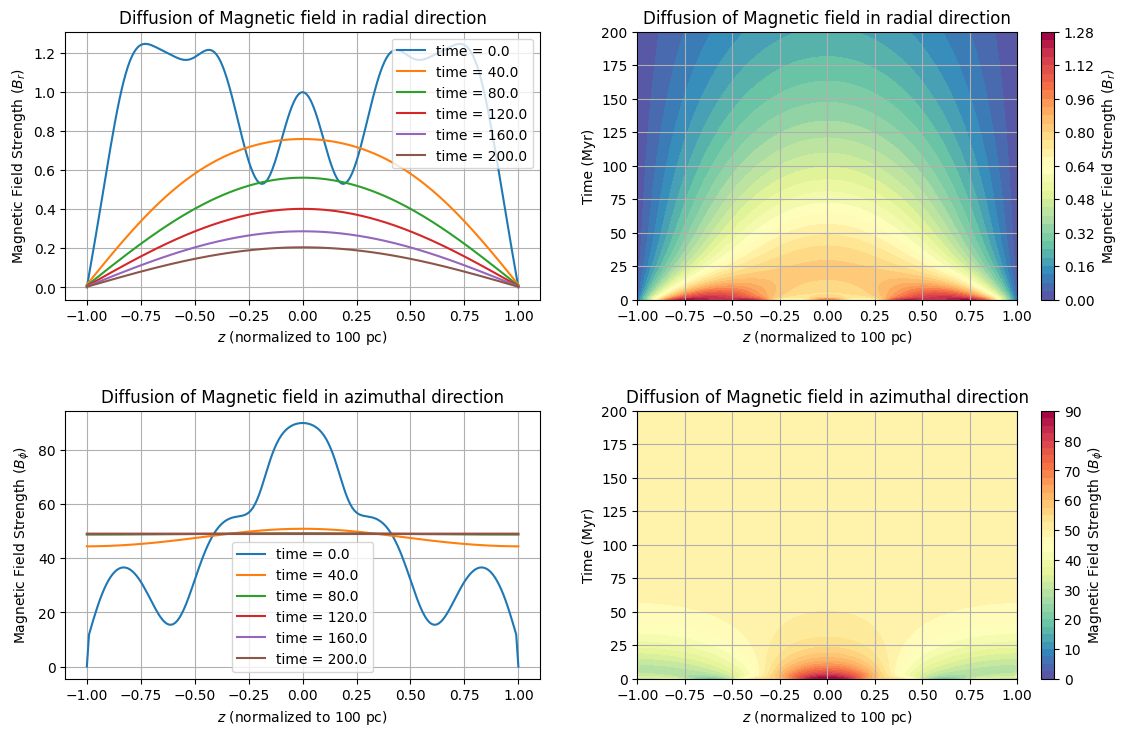

In [14]:

B, pitch = get_B_and_pitch(solution_r, solution_phi)
plot_pitch(time_grid, spatial_grid, B, pitch)
plt.show()


### Calculation of magnitude of B and pitch angle

### Decay rate calculation

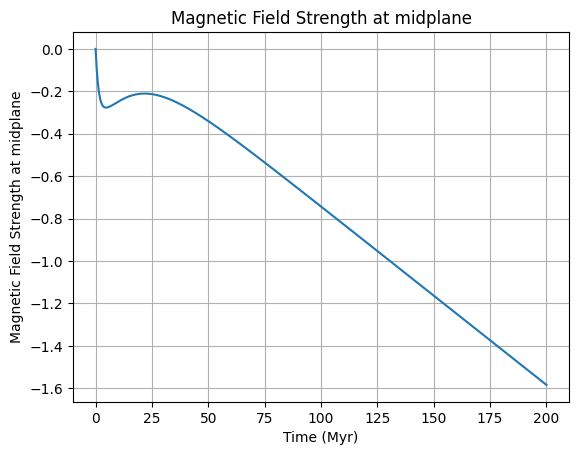

Slope of the logplot: -0.008 Myr^-1


In [15]:
B_mid = np.log(B[int(len(spatial_grid)/2), :])

plt.plot(time_grid, B_mid)
plt.xlabel('Time (Myr)')
plt.ylabel('Magnetic Field Strength at midplane')
plt.title('Magnetic Field Strength at midplane')
# plt.yscale('log')
plt.grid()
plt.show()

# get the slope of the logplot for the last 20 points
t = time_grid[-20:]
B = B_mid[-20:]
m, c = np.polyfit(t, B, 1)
print(f'Slope of the logplot: {m:.3f} Myr^-1')


#### 3.3.2 - Antisymmetric initial condition
Now let us start with an anti-symmetric case, where $B_z (z<0) = -B_z (z>0)$. We can use derivative of gaussian profile as shown in the figure below. Here, the magnetic field is zero at the midplane and but has positive and negative magnitudes in the upper and lower parts of the galactic disk respectively. 

Negative magnitudes correspond to reversal in the direction of the magnetic field.


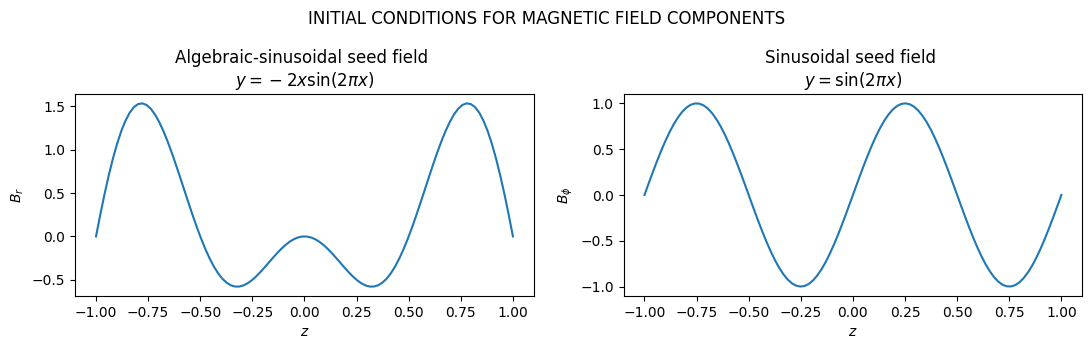

In [10]:
def init_cond_Br(x):
    return -2*x*np.sin(2*np.pi*x)
def init_cond_Bphi(x):
    return np.sin(2*np.pi*x)

plt.figure(figsize=(11, 3.5))

z = np.linspace(-1, 1, 100)
plt.subplot(121)
plt.plot(z, init_cond_Br(z))
plt.xlabel(r'$z$')
plt.ylabel(r'$B_r$')
plt.title(r'Algebraic-sinusoidal seed field '+'\n'+r'$ y = -2x\sin(2\pi x)$')

plt.subplot(122)
plt.plot(z, init_cond_Bphi(z))
plt.xlabel(r'$z$')
plt.ylabel(r'$B_{\phi}$')
plt.title(r'Sinusoidal seed field '+'\n'+r'$ y = \sin(2\pi x)$')

plt.suptitle('INITIAL CONDITIONS FOR MAGNETIC FIELD COMPONENTS')
plt.tight_layout(pad=1)
plt.show()

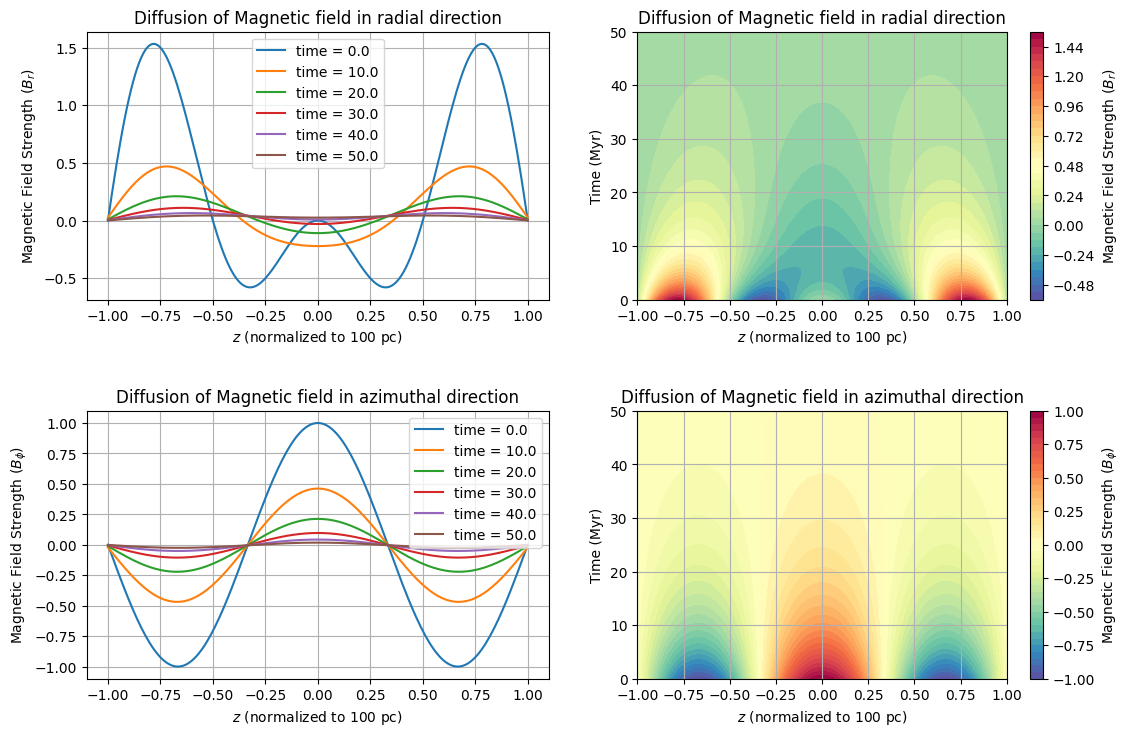

In [11]:
def init_cond_Br(x):
    return -2*x*np.sin(2*np.pi*x)
def init_cond_Bphi(x):
    return np.cos(3*np.pi/2*x)

def source_term(x, t):
    return 0 # 10 * np.sin(np.pi * x) * np.exp(-0.1 * t)

# Constants and parameters
eta_T = 3.48e-3    # magnetic diffusivity
t_max = 50     # total simulation time
z_min = -1.0     # minimum thickness of the disc
z_max = 1.0     # thickness of the disc
dt = 0.1       # time step
dz = 0.01       # spatial step in z direction

# Solve the diffusion equation in radial direction
solution_r, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Br, source_term, diff_matrix_free_boundary)
# Solve the diffusion equation in azimuthal direction
solution_phi, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Bphi, source_term, diff_matrix_free_boundary)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_r, solution_phi)

plt.show()


#### 3.3.3 - Arbitrary initial condition
Now let us move to a cmopletely arbitrary type of initial magnetic field. Consider the following profile

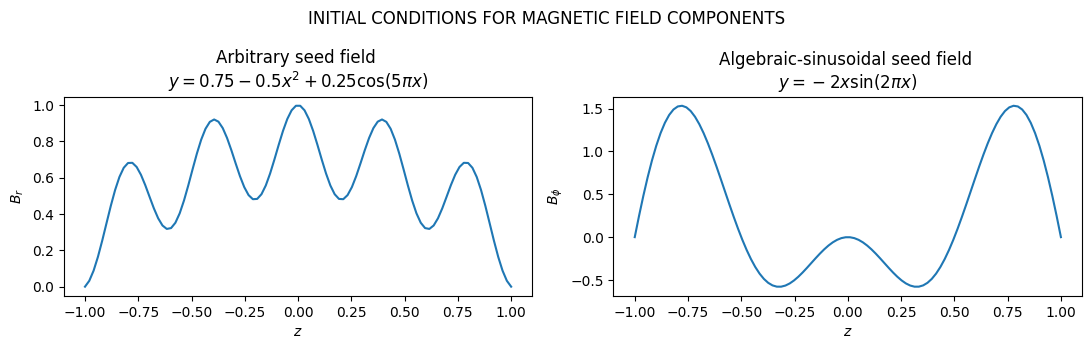

In [12]:
def init_cond_Br(x):
    return 0.75 - 0.5*x**2 + 0.25*np.cos(5*np.pi*x)
def init_cond_Bphi(x):
    return -2*x*np.sin(2*np.pi*x)

plt.figure(figsize=(11, 3.5))

z = np.linspace(-1, 1, 100)
plt.subplot(121)
plt.plot(z, init_cond_Br(z))
plt.xlabel(r'$z$')
plt.ylabel(r'$B_r$')
plt.title(r'Arbitrary seed field '+'\n'+r'$ y = 0.75 - 0.5x^2 + 0.25\cos(5\pi x)$')

plt.subplot(122)
plt.plot(z, init_cond_Bphi(z))
plt.xlabel(r'$z$')
plt.ylabel(r'$B_{\phi}$')
plt.title(r'Algebraic-sinusoidal seed field '+'\n'+r'$ y = -2x\sin(2\pi x)$')

plt.suptitle('INITIAL CONDITIONS FOR MAGNETIC FIELD COMPONENTS')
plt.tight_layout(pad=1)
plt.show()

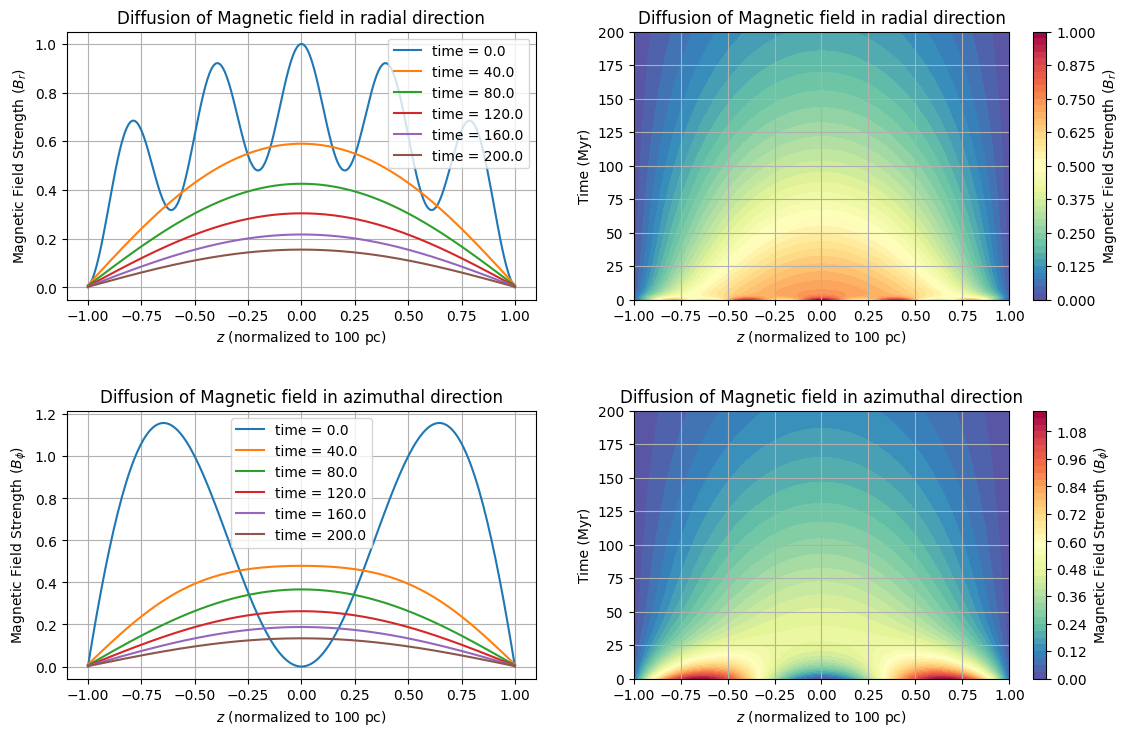

In [13]:
def init_cond_Br(x):
    return 0.75 - 0.5*x**2 + 0.25*np.cos(5*np.pi*x)
def init_cond_Bphi(x):
    return 2*x*np.sin(np.pi*x)

def source_term(x, t):
    return 0 # 10 * np.sin(np.pi * x) * np.exp(-0.1 * t)

# Constants and parameters
eta_T = 3.48e-3    # magnetic diffusivity
t_max = 200     # total simulation time
z_min = -1.0     # minimum thickness of the disc
z_max = 1.0     # thickness of the disc
dt = 0.5       # time step
dz = 0.01       # spatial step in z direction

# Solve the diffusion equation in radial direction
solution_r, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Br, source_term, diff_matrix_free_boundary)
# Solve the diffusion equation in azimuthal direction
solution_phi, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Bphi, source_term, diff_matrix_free_boundary)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_r, solution_phi)

plt.show()
